In [235]:
import os
import json
import numpy as np
import requests
import matplotlib.pyplot as plt

from scipy.interpolate import UnivariateSpline
from sklearn.metrics import mean_squared_error


In [236]:
def load_power(champion_int,lane,version=123,tier=3):
    result = {}
    time_key = f'time'
    times = np.arange(5.0, 36.0, 1.0) / 35.0
    times = np.insert(times, 0, 0.0)  # 맨 앞에 0.0 추가
    result[time_key] = times

    for region_code, region_name in region_map.items():
        url = f"https://lol.ps/api/champ/{champion_int}/graphs.json"
        params = {
            "region": region_code,
            "version": version,
            "tier": tier,
            "lane": lane,
            "range": "two_weeks"
        }
        headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)",
            "Referer": f"https://lol.ps/api/champ/{champion_int}",
            "Accept": "application/json"
        }

        try:
            response = requests.get(url, params=params, headers=headers)
            data = response.json()
            timeline_winrates = data["data"]["timelineWinrates"]
            timeline_winrates_float = np.array(list(map(float, timeline_winrates)))
            timeline_winrates_float = np.insert(timeline_winrates_float, 0, 50.0)
            result[f"po_rank_{region_name}"] = timeline_winrates_float / 100.0
        except Exception as e:
            print(f"❌ {region_name} - JSON decode error or missing data:", e)
            result[f"po_rank_{region_name}"] = None  # 또는 np.zeros(n) 등 기본값으로 설정 가능

    return result

In [237]:
def Find_champion_idx(name_us, file_path="./json/champions.json"):
    with open(file_path, "r", encoding="utf-8") as f:
        data = json.load(f)
    
    for champ in data:
        if champ["nameUs"].lower() == name_us.lower():
            return champ["championId"]
    
    return None  # 찾지 못했을 경우

In [238]:
regions = ['kr', 'eu', 'na']
region_map = {'0': 'kr', '1': 'eu', '3': 'na'}

In [239]:
def save_polyfit(champion_name, lane_num, data, degree=3, save_dir="lane_data"):
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{lane_num}.json")

    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lane_data = json.load(f)
    else:
        lane_data = {}

    lane_data[champion_name] = {}

    for region in regions:  # regions = ['kr','eu','na']
        y = data.get(f"po_rank_{region}", None)
        if y is not None:
            coeffs = np.polyfit(data["time"], y, degree)
            lane_data[champion_name][region] = coeffs.tolist()

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(lane_data, f, ensure_ascii=False, indent=2)
    print(f"save_dir='{save_dir}'")
    print(f"✅ Saved polyfit for {champion_name} in lane {lane_num}")

In [240]:
def predict_winrate(champion_name, lane_num, region, time_value, save_dir="lane_data"):
    file_path = os.path.join(save_dir, f"{lane_num}.json")
    print(f"Trying to load: {file_path} (exists: {os.path.exists(file_path)})")
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"{file_path} not found.")

    with open(file_path, "r", encoding="utf-8") as f:
        lane_data = json.load(f)

    if champion_name not in lane_data:
        raise KeyError(f"{champion_name} not found in lane {lane_num}")

    coeffs = lane_data[champion_name][region]
    return float(np.polyval(coeffs, time_value))

In [241]:
def visualize_fit(champion_name, lane_num, region, original_data, degree=3):
    x = original_data["time"]
    y = original_data[f"po_rank_{region}"]

    coeffs = np.polyfit(x, y, degree)
    x_fit = np.linspace(0, 1, 200)
    y_fit = np.polyval(coeffs, x_fit)

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, label="Original Data", color="blue")
    plt.plot(x_fit, y_fit, label=f"Polyfit deg={degree}", color="red")
    plt.title(f"{champion_name} - lane {lane_num} - {region}")
    plt.xlabel("Normalized Time")
    plt.ylabel("Winrate")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def save_spline(champion_name, lane_num, data, s=0, save_dir="./json/po/"):
    """
    s=0 → 데이터에 완전히 맞춤
    s>0 → 약간 부드럽게 보간
    """
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{lane_num}.json")

    if os.path.exists(file_path):
        with open(file_path, "r", encoding="utf-8") as f:
            lane_data = json.load(f)
    else:
        lane_data = {}

    lane_data[champion_name] = {}
    for region in region_map.values():
        y = data[f"po_rank_{region}"]
        if y is not None:
            spline = UnivariateSpline(data["time"], y, s=s)
            # spline은 저장할 때 x, y 원본을 저장해서 나중에 재생성
            lane_data[champion_name][region] = {
                "time": data["time"].tolist(),
                "y": y.tolist(),
                "s": s
            }

    with open(file_path, "w", encoding="utf-8") as f:
        json.dump(lane_data, f, ensure_ascii=False, indent=2)

    print(f"✅ Saved spline for {champion_name} in {lane_num}")

# ----------------------------
# Spline 불러오기 & 예측
# ----------------------------
def predict_spline(champion_name, lane_num, region, time_value, save_dir="lane_data_spline"):
    os.makedirs(save_dir, exist_ok=True)
    file_path = os.path.join(save_dir, f"{lane_num}.json")

    with open(file_path, "r", encoding="utf-8") as f:
        lane_data = json.load(f)

    reg_data = lane_data[champion_name][region]
    spline = UnivariateSpline(reg_data["time"], reg_data["y"], s=reg_data["s"])
    return float(spline(time_value))

In [243]:
def compare_fit_methods(champion_name, lane_name, region, original_data, degree=3, s=0):
    x = original_data["time"]
    y = original_data[f"po_rank_{region}"]

    # Polyfit
    coeffs = np.polyfit(x, y, degree)
    y_poly = np.polyval(coeffs, x)
    mse_poly = mean_squared_error(y, y_poly)

    # Spline
    spline = UnivariateSpline(x, y, s=s)
    y_spline = spline(x)
    mse_spline = mean_squared_error(y, y_spline)

    # 시각화
    x_fit = np.linspace(0, 1, 200)
    y_poly_fit = np.polyval(coeffs, x_fit)
    y_spline_fit = spline(x_fit)

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, label="Original Data", color="blue")
    plt.plot(x_fit, y_poly_fit, label=f"Polyfit deg={degree} (MSE={mse_poly:.5f})", color="red")
    plt.plot(x_fit, y_spline_fit, label=f"Spline s={s} (MSE={mse_spline:.5f})", color="green")
    plt.title(f"{champion_name} - {lane_name} - {region}")
    plt.xlabel("Normalized Time")
    plt.ylabel("Winrate")
    plt.legend()
    plt.grid(True)
    plt.show()

    return mse_poly, mse_spline

In [244]:
def visualize_spline_fit(champion_name, lane_num, region, original_data, save_dir="lane_data_spline"):
    x = np.array(original_data["time"])
    y = np.array(original_data[f"po_rank_{region}"])

    # spline 불러오기
    file_path = os.path.join(save_dir, f"{lane_num}.json")
    if not os.path.exists(file_path):
        print(f"파일이 없습니다: {file_path}")
        return

    with open(file_path, "r", encoding="utf-8") as f:
        lane_data = json.load(f)

    if champion_name not in lane_data or region not in lane_data[champion_name]:
        print(f"{champion_name} - {region} 데이터가 없습니다.")
        return

    reg_data = lane_data[champion_name][region]
    spline = UnivariateSpline(reg_data["time"], reg_data["y"], s=reg_data["s"])

    # 시각화용 x 축 범위 설정 (normalized time 0~1 범위로)
    x_fit = np.linspace(min(x), max(x), 200)
    y_fit = spline(x_fit)

    plt.figure(figsize=(6, 4))
    plt.scatter(x, y, label="Original Data", color="blue")
    plt.plot(x_fit, y_fit, label=f"Spline fit (s={reg_data['s']})", color="green")
    plt.title(f"{champion_name} - lane {lane_num} - {region} (Spline Fit)")
    plt.xlabel("Normalized Time")
    plt.ylabel("Winrate")
    plt.legend()
    plt.grid(True)
    plt.show()

save_dir='lane_data'
✅ Saved polyfit for Jax in lane 0
✅ Saved spline for Jax in 0
Trying to load: lane_data\0.json (exists: True)
t=0.00 → Polyfit: 0.4999, Spline: 0.3934


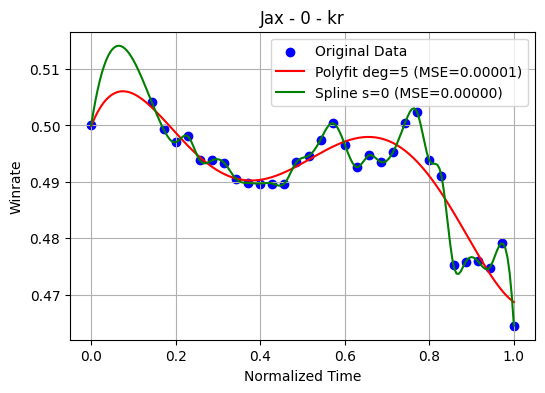

Polyfit MSE: 0.000013, Spline MSE: 0.000000


In [250]:
champion_name = "Jax"
champion_id = Find_champion_idx(champion_name)
if champion_id is None:
    print(f"Champion {champion_name} not found in champion json.")
    exit()

lane_num = 0  # 예: 0=TOP,1=JG,2=MID 등 숫자 직접 지정
data = load_power(champion_id, lane=lane_num)
save_polyfit(champion_name, lane_num, data, degree=5)
save_spline(champion_name, lane_num, data, s=0)

t = 0.00
pred_poly = predict_winrate(champion_name, lane_num, "kr", t)
pred_spl = predict_spline(champion_name, lane_num, "kr", t)
print(f"t={t:.2f} → Polyfit: {pred_poly:.4f}, Spline: {pred_spl:.4f}")

    # 5. 정확도 비교 & 시각화
mse_poly, mse_spline = compare_fit_methods(champion_name, "0", "kr", data, degree=5, s=0)
print(f"Polyfit MSE: {mse_poly:.6f}, Spline MSE: {mse_spline:.6f}")

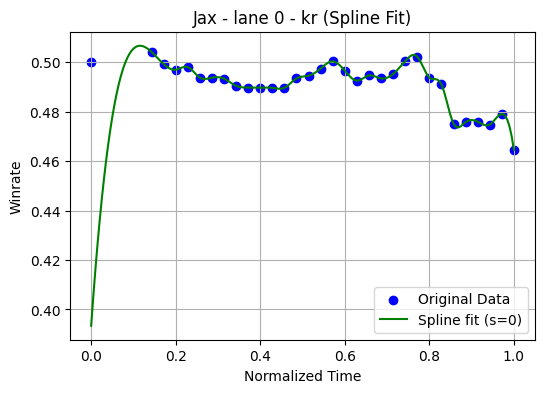

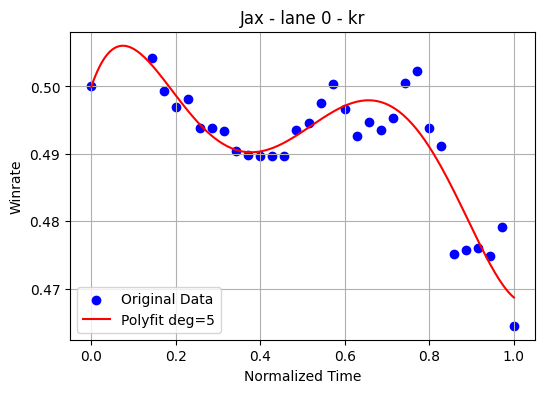

In [246]:
visualize_spline_fit(champion_name, lane_num, "kr", data)
visualize_fit(champion_name, lane_num, "kr", data, degree=5)